In [27]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

def safe_int(text, default=None):
    try:
        return int(text)
    except (ValueError, TypeError):
        return default


def safe_float(text, default=None):
    try:
        return float(text)
    except (ValueError, TypeError):
        return default


# 1. Agregamos 'headers' como parámetro para evitar el NameError
def parsear_scraping(url, headers):
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, "html.parser")
    
    equipos_html = soup.find_all("tr", class_="team")
    lista_equipos_page = []
    
    for equipo_html in equipos_html:
        dicc_equipo = {
            "Team Name": equipo_html.find("td", class_="name").get_text(strip=True),
            "Year": equipo_html.find("td", class_="year").get_text(strip=True),
            "Wins": int(equipo_html.find("td", class_="wins").get_text(strip=True)),
            "Losses": int(equipo_html.find("td", class_="losses").get_text(strip=True)),
            "OT Losses": safe_int(equipo_html.find("td", class_="ot-losses").get_text(strip=True)),
            "Win %": float(equipo_html.find("td", class_="pct").get_text(strip=True)),
            "Goals For": int(equipo_html.find("td", class_="gf").get_text(strip=True)),
            "Goals Against": int(equipo_html.find("td", class_="ga").get_text(strip=True)),
            "+/-": int(equipo_html.find("td", class_="diff").get_text(strip=True))
        }
        lista_equipos.append(dicc_equipo)
    #cada request devuelve una lista con los equipos
    return lista_equipos_page

# --- Configuración principal ---
url_base = "https://www.scrapethissite.com/pages/forms/"
headers = {"User-Agent": "Mozilla/5.0"}
lista_equipos=[]
# Hacemos la petición y guardamos la respuesta
response = requests.get(url, headers=headers, timeout=10)
soup1 = BeautifulSoup(response.content, "html.parser")

# En muchos sitios Bootstrap-like, suele haber un <ul class="pagination"> con <li><a>n</a></li>
# Cogemos TODOS los textos numéricos y nos quedamos con el máximo.
page_numbers = []
for a in soup1.select("ul.pagination a"):
    txt = a.get_text(strip=True)
    if txt.isdigit():
        page_numbers.append(int(txt))

last_page = max(page_numbers) if page_numbers else 1

base = "https://www.scrapethissite.com/pages/forms/?page_num="
for pagina in range(1,last_page+1):
    lista_pagina = parsear_scraping(base + str(pagina), headers)
    #se recorre la lista que devuelve y se añade el equipo a la lista de equipos global
    for equipo in lista_pagina:
        lista_equipos.append(equipo)


In [28]:
#- Almacena los datos de los equipos en un DataFrame y exporta a CSV (sin índices filas)
df_equipos = pd.DataFrame(lista_equipos)
df_equipos.to_csv("equipos_hockey.csv", index=False)
df_equipos.head()

,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For,Goals Against,+/-
0,Boston Bruins,1990,44,24,NaN,0.550,299,264,35
1,Buffalo Sabres,1990,31,30,NaN,0.388,292,278,14
2,Calgary Flames,1990,46,26,NaN,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,NaN,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,NaN,0.425,273,298,-25


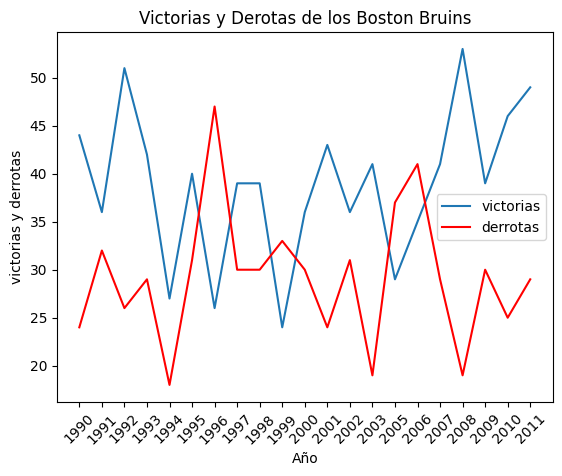

In [29]:
# - Crea un gráfico de línea con los datos de Boston Bruins.
# Una línea identifique las victorias y otra línea las derrotas para ver la evolución a lo largo de los años.
# Cada una de un color.
df_bb = df_equipos.query("`Team Name` == 'Boston Bruins'")

plt.plot(df_bb['Year'], df_bb['Wins'], label="victorias")
plt.plot(df_bb['Year'], df_bb['Losses'], label="derrotas", color='r')
plt.xlabel("Año")
plt.ylabel("victorias y derrotas")
plt.title('Victorias y Derotas de los Boston Bruins')
plt.xticks(rotation=45)
plt.legend()
plt.show()
